<span style="color:blue; font-size:20px;">Time Series Analysis - TATACOFFEE</span>


In [1]:
#install required packages
!pip install statsmodels pmdarima prophet arch statsmodels[testing] tqdm

In [2]:
# ====== 0. Imports & Settings ======
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import math
from tqdm import tqdm

# Time series libs
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

# Prophet
from prophet import Prophet

# Deep learning
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout

# VAR
from statsmodels.tsa.api import VAR

# GARCH
from arch import arch_model

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error


pandas, numpy → handle data manipulation and numeric operations.

matplotlib, seaborn → for plotting time series and diagnostics.

sns.set_style("whitegrid") → makes the charts clean and professional.

TimeSeries Libraries
STL → splits series into trend, seasonality, residual.

ACF/PACF → helps identify ARIMA orders.

ADF/KPSS → stationarity tests.

Holt-Winters models → smoothing-based forecasting.

SARIMAX → ARIMA + seasonality + external variables.

pmdarima → Auto-ARIMA model selection.

Prophet → Facebook’s forecasting model for business time series.

DeepLearning Libraries
Scaler normalizes values for neural networks.

Sequential builds neural models layer-by-layer.

LSTM/GRU layers learn long-term patterns in time series.

In [3]:
# Repro
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

In [4]:
# ====== 1. Load dataset ======
# TATACOFFEE.csv with columns: Date, Open, High, Low, Close, Volume
df = pd.read_csv("TATACOFFEE.csv", parse_dates=["Date"], index_col="Date")
df = df.sort_index()
print("Data loaded:", df.shape)
df.head()

Data loaded: (2225, 4)


,Open,High,Low,Close
Date,,,,
2013-01-01,1410.60,1427.90,1408.30,1415.10
2013-01-02,1421.00,1626.60,1416.15,1607.40
2013-01-03,1632.55,1673.90,1613.05,1626.20
2013-01-04,1627.75,1627.75,1574.60,1579.05
2013-01-07,1580.00,1639.50,1565.50,1595.65


Loads the CSV file.

Converts "Date" column to datetime and makes it index.

Sorts by date to maintain temporal order.


In [5]:
#EDA and preprocessing
# Basic info
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2225 entries, 2013-01-01 to 2021-12-28
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2225 non-null   float64
 1   High    2225 non-null   float64
 2   Low     2225 non-null   float64
 3   Close   2225 non-null   float64
dtypes: float64(4)
memory usage: 86.9 KB
None
              Open         High          Low        Close
count  2225.000000  2225.000000  2225.000000  2225.000000
mean    340.559393   346.094337   335.565528   339.695663
std     430.215976   436.921149   424.348805   429.059366
min      49.400000    50.900000    48.000000    49.400000
25%      92.600000    94.000000    91.350000    92.300000
50%     118.850000   121.400000   116.700000   118.650000
75%     212.000000   215.000000   207.950000   212.300000
max    1651.000000  1679.700000  1636.950000  1648.200000


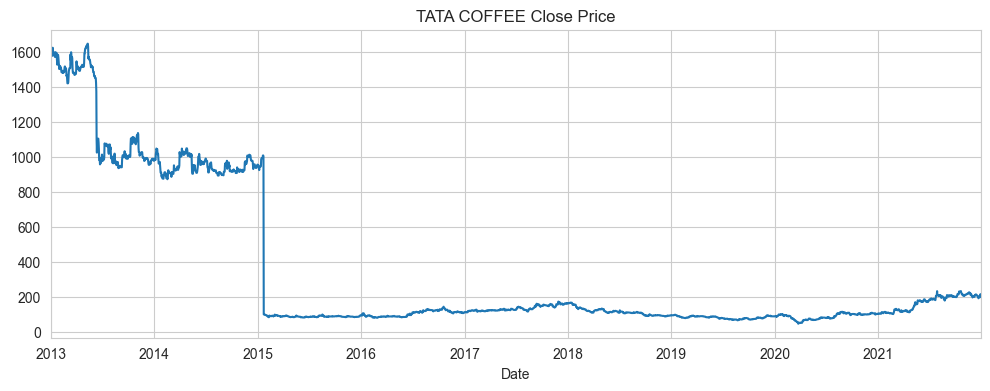

In [6]:
series = df["Close"].asfreq(None)  # keep original index frequency
series = series.fillna(method="ffill")  # forward-fill missing closes (careful with long gaps)
series.plot(title="TATA COFFEE Close Price", figsize=(12,4))
plt.show()

Close is our target variable.

Missing values are filled by forward fill (use previous day’s value).

This is common for stock prices because markets close on weekends.

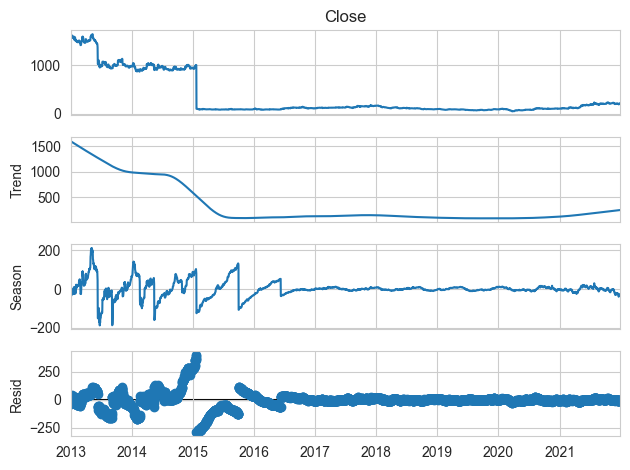

In [7]:
# STL decomposition (seasonal period set to 252 trading days ~ 1 year). 
stl = STL(series, period=252 if len(series)>300 else max(5, int(len(series)/6)))
res = stl.fit()
res.plot()
plt.show()

STL separates the series into:
Trend + Seasonality + Noise

Helps visualize patterns before modelling.

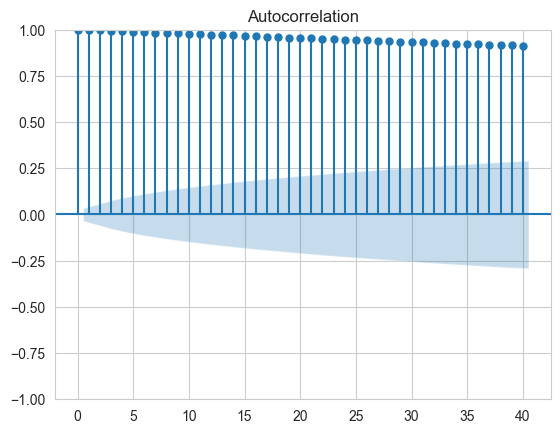

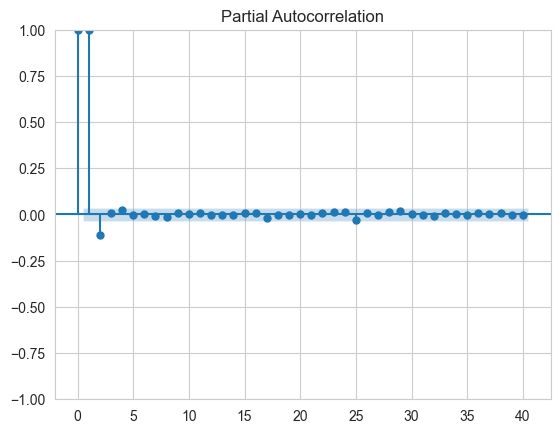

In [8]:
# ACF / PACF
plot_acf(series.dropna(), lags=40)
plot_pacf(series.dropna(), lags=40)
plt.show()

Autocorrelation Function (ACF) helps identify the order, \(q\), for a Moving Average (MA) model
Partial Autocorrelation Function (PACF) helps identify the order, \(p\), for an Autoregressive (AR) model.

In [9]:
# ADF test (Augmented Dickey-Fuller)
def adf_test(x):
    res = adfuller(x.dropna())
    print("ADF statistic:", res[0])
    print("p-value:", res[1])
    for k,v in res[4].items():
        print("Critical value (%s): %.3f" % (k, v))

adf_test(series)

ADF statistic: -3.019351933359799
p-value: 0.03312627049524297
Critical value (1%): -3.432
Critical value (5%): -2.862
Critical value (10%): -2.567


In [10]:
# KPSS test
from statsmodels.tsa.stattools import kpss
def kpss_test(x):
    stat, p, lags, crit = kpss(x.dropna(), nlags="auto")
    print("KPSS statistic:", stat)
    print("p-value:", p)
    print("lags:", lags)
    print("crit:", crit)

kpss_test(series)

KPSS statistic: 4.923180518780984
p-value: 0.01
lags: 37
crit: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\GOWTHAM\AppData\Local\Temp\ipykernel_15692\923274684.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, p, lags, crit = kpss(x.dropna(), nlags="auto")


ADF null hypothesis = “Series is non-stationary”

KPSS null hypothesis = “Series is stationary”

If both agree, your decision is strong:

ADF p<0.05 → stationary

KPSS p>0.05 → stationary

If conflicting → difference the data.

In [11]:
#Train-test split (time-based)
# train-test split by date or proportion
train_size = int(len(series) * 0.8)
train = series.iloc[:train_size]
test = series.iloc[train_size:]

print("Train length:", len(train), "Test length:", len(test))


Train length: 2627 Test length: 657


First 80% → training

Last 20% → testing

Time series CANNOT use random split.

In [12]:
#Utility functions
def rmse(y_true, y_pred): return math.sqrt(mean_squared_error(y_true, y_pred))
def evaluate(y_true, y_pred, label="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    r = rmse(y_true, y_pred)
    print(f"{label} -> MAE: {mae:.4f}, RMSE: {r:.4f}")


<span style="color:orange; font-size:20px;">Algorithm - Moving Average baseline</span>

In [13]:
window = 10
ma_pred = train.rolling(window).mean().iloc[-1]  # naive single value baseline
# For a proper MA forecast you can use rolling mean of last window as constant forecast for horizon
h = len(test)
ma_forecast = np.repeat(train.tail(window).mean(), h)

evaluate(test.values, ma_forecast, label=f"MA(window={window})")


MA(window=10) -> MAE: 61.3729, RMSE: 78.9910


<span style="color:orange; font-size:20px;">Algorithm - Simple Exponential Smoothing</span>

In [14]:
ses = SimpleExpSmoothing(train).fit()
ses_forecast = ses.forecast(len(test))
evaluate(test, ses_forecast, label="SES")


SES -> MAE: 65.1959, RMSE: 82.6537


<span style="color:orange; font-size:20px;">Algorithm - Holt & Holt-Winters</span>

In [15]:
# Holt (trend)
holt = Holt(train).fit()
holt_forecast = holt.forecast(len(test))
evaluate(test, holt_forecast, label="Holt")

# Holt-Winters (additive) 
seasonal_periods = 252 if len(series) > 300 else max(5, int(len(series)/6))
hw = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=seasonal_periods).fit()
hw_forecast = hw.forecast(len(test))
evaluate(test, hw_forecast, label="Holt-Winters")


Holt -> MAE: 410.9631, RMSE: 481.0490
Holt-Winters -> MAE: 215.8469, RMSE: 257.3268


C:\Anaconda\envs\aiml\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<span style="color:orange; font-size:20px;">Algorithm - Prophet</span>

In [17]:
# Prepare dataframe
prophet_df = train.reset_index().rename(columns={'Date':'ds','Close':'y'}) if 'Date' in train.reset_index().columns else train.reset_index().rename(columns={'index':'ds', 'Close':'y'})
# ensure proper columns
prophet_df = pd.DataFrame({'ds':train.index, 'y':train.values})

m = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
# Optionally: m.add_country_holidays(country_name='IN')
m.fit(prophet_df)

future = m.make_future_dataframe(periods=len(test), freq='D')
forecast = m.predict(future)
prophet_pred = forecast['yhat'].iloc[-len(test):].values
evaluate(test.values, prophet_pred, "Prophet")


16:11:48 - cmdstanpy - INFO - Chain [1] start processing
16:11:49 - cmdstanpy - INFO - Chain [1] done processing


Prophet -> MAE: 75.9264, RMSE: 94.7600


<span style="color:orange; font-size:20px;">Agorithm - LSTM (Deep Learning)</span>

In [18]:
# 1. Prepare data (MinMax scale)
scaler = MinMaxScaler()
scaled = scaler.fit_transform(series.values.reshape(-1,1))

# Use last N days as sequence
SEQ = 60  # window length
def create_sequences(data, seq_len=SEQ):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled)
# Align train-test indices
train_X = X[:train_size-SEQ]
train_y = y[:train_size-SEQ]
test_X = X[train_size-SEQ:]
test_y = y[train_size-SEQ:]

# reshape for LSTM: (samples, timesteps, features)
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))

# Build model (small)
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(train_X.shape[1],1)),
    LSTM(50),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')

# Train (note: reduce epochs if long)
history = model_lstm.fit(train_X, train_y, epochs=20, batch_size=32,
                         validation_data=(test_X, test_y), verbose=1)

# Forecast one-step on test set (direct predictions)
pred_test_scaled = model_lstm.predict(test_X)
pred_test = scaler.inverse_transform(pred_test_scaled)

# True test values (aligned)
true_test = series.values[train_size:]
evaluate(true_test[:len(pred_test)], pred_test.flatten(), "LSTM (one-step)")


Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0252 - val_loss: 7.5998e-05
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0013 - val_loss: 4.6156e-05
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0012 - val_loss: 4.2321e-05
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0011 - val_loss: 2.9673e-05
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0011 - val_loss: 2.0600e-05
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0010 - val_loss: 1.8080e-05
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 9.2801e-04 - val_loss: 1.8347e-05
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 8.6049e-04 - val_loss: 1.9691e-05
Epoch 9/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 8.0202e-04 - val_loss: 2.1107e-05
Epoch 10/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 7.4505e-04 - val_loss: 2.2270e-05
Epoch 11/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 6.8962e-04 - val_loss: 2.2884e-05

Algorithm - GRU (Deep Learning)

In [19]:
# Prepare same train_X, train_y, test_X, test_y
model_gru = Sequential([
    GRU(64, return_sequences=True, input_shape=(train_X.shape[1],1)),
    GRU(32),
    Dense(1)
])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(train_X, train_y, epochs=20, batch_size=32, validation_data=(test_X, test_y))
pred_gru = scaler.inverse_transform(model_gru.predict(test_X))
evaluate(true_test[:len(pred_gru)], pred_gru.flatten(), "GRU")


Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - loss: 0.0209 - val_loss: 1.3679e-05
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 5.6261e-04 - val_loss: 1.8090e-05
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 5.0717e-04 - val_loss: 1.8784e-05
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 4.5985e-04 - val_loss: 2.7402e-05
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 4.2051e-04 - val_loss: 3.0004e-05
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 3.9036e-04 - val_loss: 2.7239e-05
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 3.6469e-04 - val_loss: 2.2947e-05
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 3.4055e-04 - val_loss: 1.9752e-05
Epoch 9/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 3.1900e-04 - val_loss: 1.8346e-05
Epoch 10/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 3.0191e-04 - val_loss: 1.8212e-05
Epoch 11/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 2.8950e-04 - 

<span style="color:orange; font-size:20px;">Algorithm - ARIMA</span>

In [25]:
from statsmodels.tsa.arima.model import ARIMA
arima_model = ARIMA(train, order=(2,1,2))
arima_res = arima_model.fit()

# Forecast
arima_pred = arima_res.forecast(steps=len(test))

# Evaluation
arima_mae = mean_absolute_error(test, arima_pred)
arima_rmse = np.sqrt(mean_squared_error(test, arima_pred))

print("ARIMA MAE:", arima_mae)
print("ARIMA RMSE:", arima_rmse)

ARIMA MAE: 65.06938081597364
ARIMA RMSE: 82.53637332195814


<span style="color:orange; font-size:20px;">Algorithm - SARIMA</span>

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA model
sarima_model = SARIMAX(train, order=(2,1,2), seasonal_order=(1,1,1,7))
sarima_res = sarima_model.fit()

# Forecast
sarima_pred = sarima_res.get_forecast(steps=len(test)).predicted_mean

# Evaluation
sarima_mae = mean_absolute_error(test, sarima_pred)
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_pred))

print("SARIMA MAE:", sarima_mae)
print("SARIMA RMSE:", sarima_rmse)


SARIMA MAE: 219.71910337581878
SARIMA RMSE: 260.01627632875983


<span style="color:orange; font-size:20px;">Algorithm - GARCH (volatility modelling)</span>

In [31]:
# Use returns (log returns preferred)
returns = df["Close"].pct_change().dropna()*100  # percentage returns
am = arch_model(returns, vol="Garch", p=1, q=1, mean="Zero")
res_garch = am.fit(disp="off")
print(res_garch.summary())
# Forecast variance (volatility) for next steps
garch_fore = res_garch.forecast(horizon=len(test))
# extract variance forecasts:
var_fore = garch_fore.variance.iloc[-1].values


                       Zero Mean - GARCH Model Results                        
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5541.41
Distribution:                  Normal   AIC:                           11088.8
Method:            Maximum Likelihood   BIC:                           11105.9
                                        No. Observations:                 2224
Date:                Fri, Nov 14 2025   Df Residuals:                     2224
Time:                        16:43:56   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          2.1350      1.883      1.134      0.257 

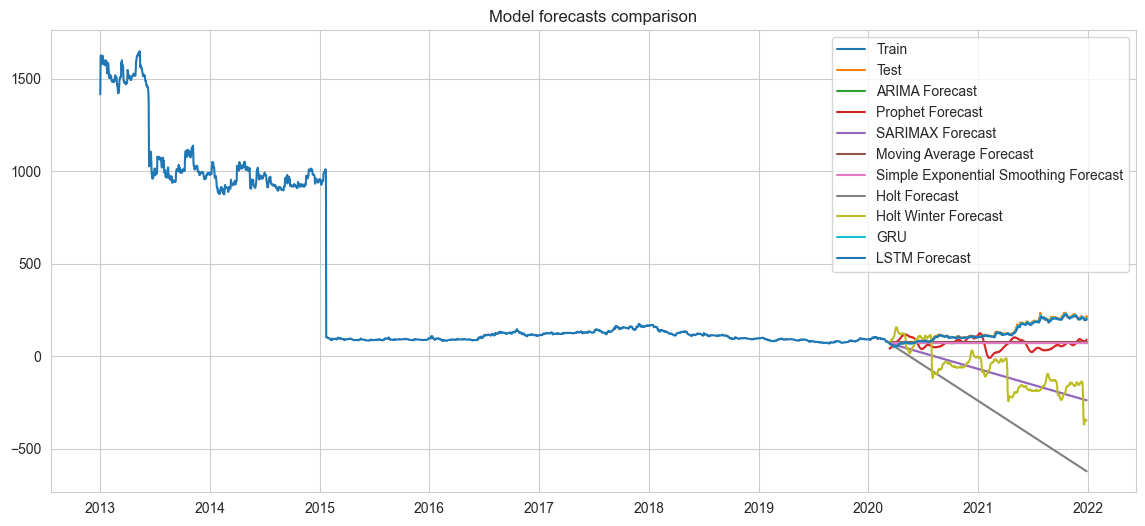

In [36]:
#Plotting forecasts vs actuals

plt.figure(figsize=(14,6))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(test.index, arima_pred, label="ARIMA Forecast")
plt.plot(test.index, prophet_pred, label="Prophet Forecast")
plt.plot(test.index, sarima_pred, label="SARIMAX Forecast")
plt.plot(test.index, ma_forecast, label="Moving Average Forecast")
plt.plot(test.index, ses_forecast, label="Simple Exponential Smoothing Forecast")
plt.plot(test.index, holt_forecast, label="Holt Forecast")
plt.plot(test.index, hw_forecast, label="Holt Winter Forecast")
plt.plot(test.index, pred_gru, label="GRU")
plt.plot(test.index[:len(pred_test)], pred_test.flatten(), label="LSTM Forecast")
plt.legend()
plt.title("Model forecasts comparison")
plt.show()

Interpretation: 

From 2013 to 2014, price was high and volatile (₹900–1600 range).

In 2015, there is a sudden drop to around ₹100 — a clear regime shift.

From 2016 to 2019, prices are stable and low-volatility.

After 2020, the stock shows a steady upward trend.